# **Imports**

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import matplotlib.dates as mdates


# **Guidelines**

You’re free to use any language, any tool.

Use the dataset attached (zip csv) to answers the following questions in a commented notebook to share (github link ideally sent back to this email):

- Anything you can say what this dataset is about
- What does the dataset tell you about the game matches ?
- How would you assess data quality ? Any anomaly or outlier you can detect
- Compute all players win/lose ratio and display distribution
- Compute all players max defeat and victory in a row
- Compute/aggregate other players features you think are relevant and keep all players features in a dataframe
- Based on the players features computed, can you think of a method to predict the 'still_active' one (explain what you would do, no need to write  working code)
- How would you analyse players features importance for still_active predictor (explain what you would do, no need to write working code)
 

Do not hesitate to email me if further questions

# **Loading data and quick overview**

In [2]:
path = "player_match_sample.csv"

df = pd.read_csv(path)
df.head()

,PLAYERID,MATCHID,TEAM,DURATION,VICTORY,MATCHDATEID,STILL_ACTIVE
0,11664,290014,B,1344319,1,20250804,True
1,12905,234898,A,1326880,0,20250804,False
2,14122,171447,B,2107402,1,20250804,False
3,14217,248885,B,1027924,0,20250804,True
4,13799,199453,A,1308102,0,20250804,True


# **Quick Preprocessing**

Renamin columns to lower case for simplicity

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655722 entries, 0 to 655721
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   playerid      655722 non-null  int64 
 1   matchid       655722 non-null  int64 
 2   team          655722 non-null  object
 3   duration      655722 non-null  int64 
 4   victory       655722 non-null  int64 
 5   matchdateid   655722 non-null  int64 
 6   still_active  655722 non-null  bool  
dtypes: bool(1), int64(5), object(1)
memory usage: 30.6+ MB


Converting match date and duration to appropriate types (datetime and minutes)

In [4]:
df['victory'] = df['victory'].astype(int)
df['still_active'] = df['still_active'].astype(bool)
df['matchdateid'] = pd.to_datetime(df['matchdateid'], format='%Y%m%d')


df['duration'] = pd.to_timedelta(df['duration'], unit='ms', errors='coerce')

df['duration_seconds'] = df['duration'].dt.total_seconds()
df['duration_minutes'] = df['duration_seconds'] / 60

df['year'] = df['matchdateid'].dt.year
df['month'] = df['matchdateid'].dt.month
df['day'] = df['matchdateid'].dt.day
df['weekday'] = df['matchdateid'].dt.weekday  

# **Q1. Anything you can say what this dataset is about ?** 

This dataset seems to contains **player-level match data** played during august 2025 from a multiplayer game (which, as we will see later, can be played in solo and is actually mainly played in solo).  
Each row represents the participation of **one player in one match**, which is confirmed by the fact that almost all `('playerid', 'matchid')` pairs are unique, as seen in the next cell.

My hypothesis is that the **10 duplicated pairs** appear to be **ETL or ingestion artifacts**, as they represent an extremely small fraction of the dataset. All duplicated rows share identical match characteristics but differ by exactly one day in `matchdateid`, supporting the hypothesis of a data collection or snapshot duplication issue.

Each row provides the following information about a player’s participation in a match:

- **playerid** : unique identifier of the player  
- **matchid** : unique identifier of the match  
- **team** : team assignment for the match  
- **duration** : duration of the match  
- **victory** : win/loss outcome for the player  
- **matchdateid** : date of the match  
- **still_active** : whether the player is still active currently, not during the time of the match. This hypothesis is supported by the fact that all players have a unique consistent **still_active** value through all their matches as shown inb the second cell, meaning that it is their curent active state.


In [5]:
df.matchdateid.min(), df.matchdateid.max() 

(Timestamp('2025-08-02 00:00:00'), Timestamp('2025-09-01 00:00:00'))

In [6]:
df[df.duplicated(subset=['playerid', 'matchid'],keep=False)]

,playerid,matchid,team,duration,victory,matchdateid,still_active,duration_seconds,duration_minutes,year,month,day,weekday
51781,11973,300268,B,0 days 00:36:20.318000,0,2025-08-06,True,2180.318,36.338633,2025,8,6,2
68705,14308,199751,A,0 days 00:26:39.815000,0,2025-08-22,False,1599.815,26.663583,2025,8,22,4
109178,11973,300268,B,0 days 00:36:20.318000,0,2025-08-05,True,2180.318,36.338633,2025,8,5,1
147946,14308,199751,A,0 days 00:26:39.815000,0,2025-08-21,False,1599.815,26.663583,2025,8,21,3
206764,11746,401916,A,0 days 00:20:49.937000,0,2025-08-09,True,1249.937,20.832283,2025,8,9,5
237431,10941,218268,A,0 days 00:31:25.687000,0,2025-08-21,True,1885.687,31.428117,2025,8,21,3
386534,11746,401916,A,0 days 00:20:49.937000,0,2025-08-08,True,1249.937,20.832283,2025,8,8,4
467935,10941,218268,A,0 days 00:31:25.687000,0,2025-08-20,True,1885.687,31.428117,2025,8,20,2
474188,13531,266348,A,0 days 00:30:37.650000,0,2025-08-10,True,1837.650,30.627500,2025,8,10,6
485253,13531,266348,A,0 days 00:30:37.650000,0,2025-08-09,True,1837.650,30.627500,2025,8,9,5


In [7]:
df.groupby('playerid')['still_active'].nunique().value_counts()


still_active
1    6383
Name: count, dtype: int64

# **Q2. How would you assess data quality ? Any anomaly or outlier you can detect**

To provide a coherent analysis for Question 2 : **“What does the dataset tell you about the game matches?”**, I switched the order with Q3 in order to start with the data quality question first.  
This ensures that outliers and corrupted records do not distort our understanding of the actual match dynamics.

### **1. Null values check**

It seems there are no empty values

In [8]:
df.isna().sum()

playerid            0
matchid             0
team                0
duration            0
victory             0
matchdateid         0
still_active        0
duration_seconds    0
duration_minutes    0
year                0
month               0
day                 0
weekday             0
dtype: int64

### **2. Duplicate rows**

The only duplicates that matter are those in the `(playerid, matchid)` pair, since a player should not appear twice in the same match. One theoretical exception would be if a player disconnected and reconnected, but this does not apply here: all duplicated pairs occur with a one-day difference in `matchdateid`, meaning the match would have ended long before the second entry.

Another possible explanation is that the match started just before midnight and ended after midnight, which could cause the system to assign two different dates. However, even if this scenario were true, keeping these duplicates would bias our analysis.

Since the number of duplicates is extremely small and removing them does not affect the dataset in any meaningful way, we choose to drop all duplicated `(playerid, matchid)` rows.


In [9]:
# Duplicates
n_dups = df.duplicated(subset=['playerid', 'matchid']).sum()
print("Number of duplicates:", n_dups)

# Clean version without duplicates
df_clean = df.drop_duplicates(subset=['playerid', 'matchid']).copy()

duplicates = df[df.duplicated(subset=['playerid', 'matchid'], keep=False)]
duplicates

Number of duplicates: 5


,playerid,matchid,team,duration,victory,matchdateid,still_active,duration_seconds,duration_minutes,year,month,day,weekday
51781,11973,300268,B,0 days 00:36:20.318000,0,2025-08-06,True,2180.318,36.338633,2025,8,6,2
68705,14308,199751,A,0 days 00:26:39.815000,0,2025-08-22,False,1599.815,26.663583,2025,8,22,4
109178,11973,300268,B,0 days 00:36:20.318000,0,2025-08-05,True,2180.318,36.338633,2025,8,5,1
147946,14308,199751,A,0 days 00:26:39.815000,0,2025-08-21,False,1599.815,26.663583,2025,8,21,3
206764,11746,401916,A,0 days 00:20:49.937000,0,2025-08-09,True,1249.937,20.832283,2025,8,9,5
237431,10941,218268,A,0 days 00:31:25.687000,0,2025-08-21,True,1885.687,31.428117,2025,8,21,3
386534,11746,401916,A,0 days 00:20:49.937000,0,2025-08-08,True,1249.937,20.832283,2025,8,8,4
467935,10941,218268,A,0 days 00:31:25.687000,0,2025-08-20,True,1885.687,31.428117,2025,8,20,2
474188,13531,266348,A,0 days 00:30:37.650000,0,2025-08-10,True,1837.650,30.627500,2025,8,10,6
485253,13531,266348,A,0 days 00:30:37.650000,0,2025-08-09,True,1837.650,30.627500,2025,8,9,5


### **3. Match duration**

With this statistics overview of the match durations, we notice there are some outlier values, as the max duration time for a match is 424349 minutes, while the average time is 26 minutes. Next we will check how much outliers we have

In [10]:
df_clean.duration_minutes.describe()

count    655717.000000
mean         26.570712
std        1658.773083
min           0.000000
25%          13.189550
50%          18.884533
75%          25.292133
max      424349.445083
Name: duration_minutes, dtype: float64

Converting match date and duration to appropriate types (datetime and minutes)

Lets consider a treshold of for a duration time of a given match, in order to check how much outliers we have in this category. As a point of reference, lets check the duration corresponding to the 99.99th percentile, meaning the top 0.01% longest match time.  

In [11]:
p_99 = df_clean.duration_minutes.quantile(0.9999)
print(f"99.99th percentile duration time: {p_99} minutes")

99.99th percentile duration time: 49.61802043999985 minutes


**It is reasonable to assume that any match duration longer than 1 hour and 30 minutes is an outlier, especially since the 99.99th percentile is around 49 minutes**. **There are two common strategies for handling such outliers:**

- **Removing the rows** containing outlier values  
- **Replacing outliers** with a chosen statistic, such as the mean or the most frequent value

While removing a small number of outliers (12 in this case) would normally be acceptable, the rows in this dataset are not independent: they are linked by matches. Deleting rows would alter the composition of certain matches, affecting statistics such as the number of players per match and potentially biasing downstream analyses.

For this reason, I chose to **replace outlier durations with the mean match duration**, preserving the structure of all matches while neutralizing the impact of outlier values.


Number of outliers with duration > 90 minutes: 12
Outliers (> 90 min) BEFORE removal: 12
Outliers (> 90 min) AFTER replacement: 0


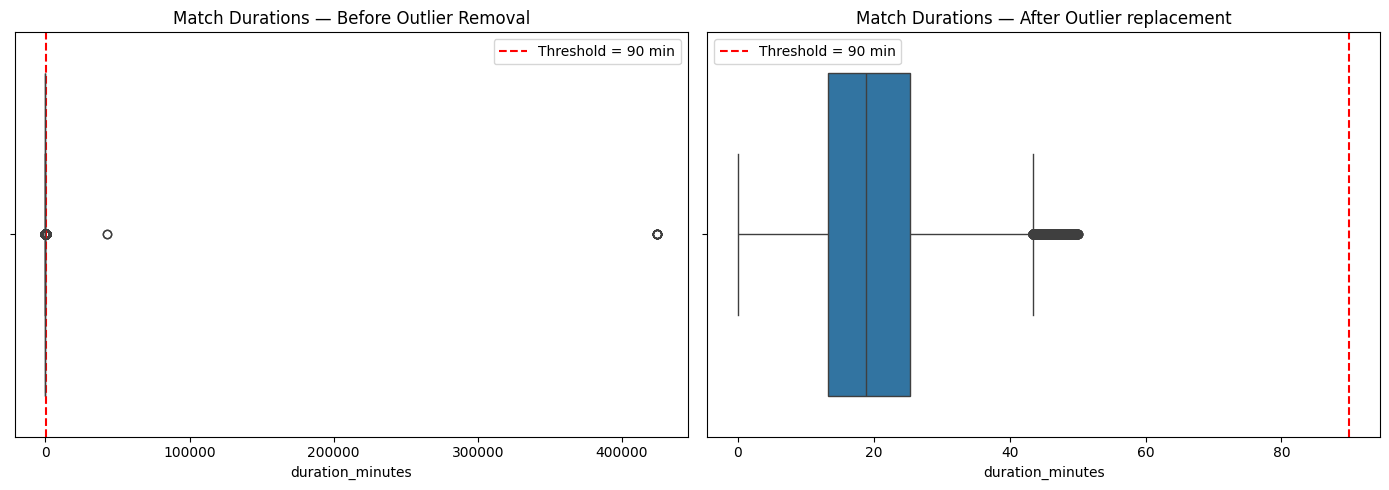

In [ ]:
threshold = 90
nb_outliers = len(df_clean[df_clean.duration_minutes > threshold])
print(f"Number of outliers with duration > {threshold} minutes: {nb_outliers}")

dur_mean = df_clean.loc[df_clean['duration_minutes'] <= threshold, 'duration_minutes'].mean()
df_after = df_clean.copy()
df_after.loc[df_after['duration_minutes'] > threshold, 'duration_minutes'] = dur_mean

nb_out_after = len(df_after[df_after['duration_minutes'] > threshold])

print(f"Outliers (> {threshold} min) BEFORE removal: {nb_outliers}")
print(f"Outliers (> {threshold} min) AFTER replacement: {nb_out_after}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BEFORE
sns.boxplot(ax=axes[0], x=df_clean['duration_minutes'])
axes[0].axvline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold} min")
axes[0].set_title("Match Durations — Before Outlier Removal")
axes[0].legend()

# AFTER
sns.boxplot(ax=axes[1], x=df_after['duration_minutes'])
axes[1].axvline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold} min")
axes[1].set_title("Match Durations — After Outlier replacement")
axes[1].legend( )

plt.tight_layout()
plt.show()


We have removed all obvious outliers. Now, as we can see in the second boxplot, there are still values outside the InterQuartile Range, aproximately at 43 minutes. We could consider them outliers as well, but without knowledge on the game mecanics or an expert outlook, it is not safe to assume these values are outliers, so we will keep them. 

### **4. Teams**

**The team distribution shows that almost all players are assigned to either Team A or Team B, with a very balanced split between the two**. A small number of rows (749) are labeled as **Team X**. Given how small this group is compared to the overall dataset, and considering that the two main teams each represent roughly 50% of the players, which aligns with the law of large numbers for a two-team game, **it is unlikely that Team X corresponds to an actual in-game team**. Instead, it most likely represents incomplete or corrupted team assignments in the data. Possible reasons for a Team X assignment include:

- The player joined or left the match before the team assignment was properly recorded  
- A logging failure during the match  
- A player in a transitional state, like loading screen, reconnecting, or spectator mode  
- Corrupted or partial match records, especially in edge cases or interrupted sessions  
- ETL or ingestion inconsistencies when transforming raw data into this dataset  

**Given the very small volume and the lack of information needed to reconstruct the correct team, we will delete these rows.**


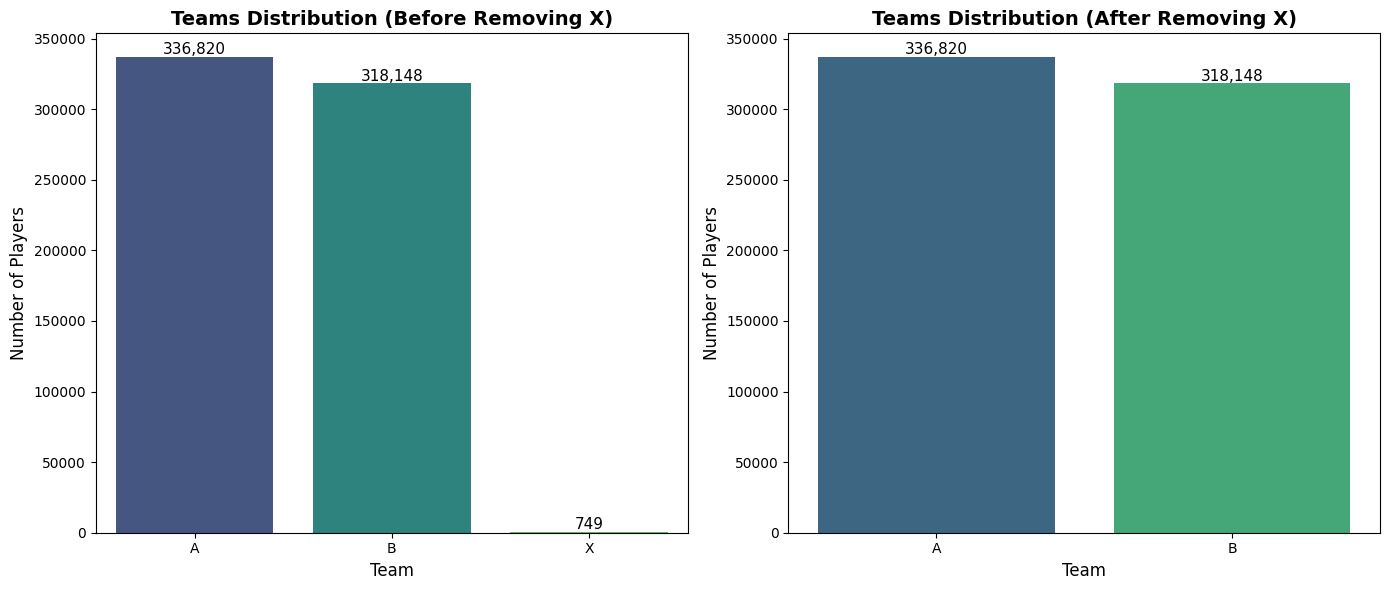

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

team_counts = df_after['team'].value_counts()

### BEFORE REMOVAL OF TEAM X
sns.barplot(
    ax=axes[0],
    x=team_counts.index,
    y=team_counts.values,
    hue=team_counts.index,
    palette="viridis",
    legend=False
)

axes[0].set_title("Teams Distribution (Before Removing X)", fontsize=14, weight='bold')
axes[0].set_xlabel("Team", fontsize=12)
axes[0].set_ylabel("Number of Players", fontsize=12)

for i, v in enumerate(team_counts.values):
    axes[0].text(i, v + 2000, f"{v:,}", ha='center', fontsize=11)


### AFTER REMOVAL OF TEAM X
df_clean_teams = df_after[df_after['team'].isin(['A', 'B'])].copy()
team_counts_clean = df_clean_teams['team'].value_counts()

sns.barplot(
    ax=axes[1],
    x=team_counts_clean.index,
    y=team_counts_clean.values,
    hue=team_counts_clean.index,
    palette="viridis",
    legend=False
)

axes[1].set_title("Teams Distribution (After Removing X)", fontsize=14, weight='bold')
axes[1].set_xlabel("Team", fontsize=12)
axes[1].set_ylabel("Number of Players", fontsize=12)

for i, v in enumerate(team_counts_clean.values):
    axes[1].text(i, v + 2000, f"{v:,}", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


### **5. Match consistency - number of players per match**

There is a **dominant proportion of one-player matches**, which is unusual for a typical multiplayer game. **The maximum number of players observed in a match is** **12**, which is coherent, but it occurs only **once** in the entire dataset and may therefore represent an outlier. However, since we do not know which specific game this dataset comes from, **we cannot safely remove or filter rows based solely on the number of players per match**. It is therefore better to keep the full distribution intact to avoid making incorrect assumptions about the game's intended match structure.


In [14]:
players_per_match = df_clean_teams.matchid.value_counts().reset_index(name="number_of_players")
players_per_match_dist = players_per_match.number_of_players.value_counts().sort_index()
players_per_match_dist

number_of_players
1     453968
2      71634
3      12951
4       2410
5        421
6         88
7         72
8        146
9        210
10       301
11         2
12         1
Name: count, dtype: int64

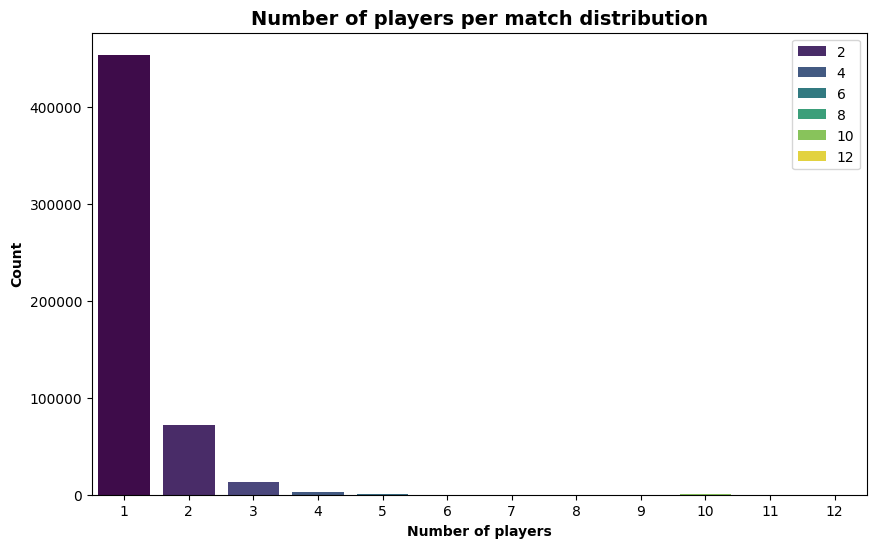

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x=players_per_match_dist.index, y=players_per_match_dist.values, hue=players_per_match_dist.index ,palette="viridis")
plt.title("Number of players per match distribution", fontsize=14, weight="bold")
plt.xlabel("Number of players",weight="bold")
plt.ylabel("Count",weight="bold")
plt.legend()
plt.show()

### **6. Still_active column**

If my understanding is correct, the `still_active` column **represents the player's current status**, not their status at the time of each recorded match. It likely indicates whether the player is still active in the game as of the dataset's extraction date. Therefore, each player should have a consistent `still_active` value across all their matches. This hypothesis is confirmed by the computation below: every player has exactly one unique `still_active` value.


In [16]:
df_clean_teams.groupby("playerid")["still_active"].nunique().value_counts().reset_index(name="Number_of_players").rename(columns={"still_active":"number_of_unique_still_active_values"})

,number_of_unique_still_active_values,Number_of_players
0,1,6383


There are some matches with more than one date, we will not delete them as there are only a few. 

In [17]:
date_consistency = (
    df_after.groupby('matchid')['matchdateid']
    .nunique()
    .reset_index(name='distinct_dates')
)

# Matches with more than 1 unique date
inconsistent_matches = date_consistency[date_consistency['distinct_dates'] > 1]
inconsistent_matches


,matchid,distinct_dates
47558,48558,2
65442,66442,2
96977,97977,2
99687,100687,2
149292,150292,2
198751,199751,2
201213,202213,2
233806,234806,2
250151,251151,2
265749,266749,2


In [ ]:
df_after[df_after['matchid'].isin(inconsistent_matches['matchid'])].sort_values(['matchid', 'matchdateid'])

,playerid,matchid,team,duration,victory,matchdateid,still_active,duration_seconds,duration_minutes,year,month,day,weekday
346244,11636,48558,B,0 days 00:21:24.766000,0,2025-08-25,True,1284.766,21.412767,2025,8,25,0
433956,10069,48558,B,0 days 00:21:24.763000,0,2025-08-26,True,1284.763,21.412717,2025,8,26,1
15366,11677,66442,B,0 days 00:30:09.691000,0,2025-08-29,True,1809.691,30.161517,2025,8,29,4
588338,10415,66442,B,0 days 00:06:32.561000,0,2025-08-29,True,392.561,6.542683,2025,8,29,4
545590,14357,66442,B,0 days 00:30:09.740000,0,2025-08-30,True,1809.740,30.162333,2025,8,30,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
243494,12481,506694,A,0 days 00:38:32.686000,1,2025-08-03,True,2312.686,38.544767,2025,8,3,6
511575,12098,506694,A,0 days 00:38:32.554000,1,2025-08-04,True,2312.554,38.542567,2025,8,4,0
420454,10422,524139,A,0 days 00:18:43.935000,0,2025-08-28,True,1123.935,18.732250,2025,8,28,3
619161,13579,524139,A,0 days 00:18:43.938000,0,2025-08-28,False,1123.938,18.732300,2025,8,28,3


# **Q3. What does the dataset tell you about the game matches ?**

In [19]:
df_clean_final = df_clean_teams.copy()
df_clean_final.columns

Index(['playerid', 'matchid', 'team', 'duration', 'victory', 'matchdateid',
       'still_active', 'duration_seconds', 'duration_minutes', 'year', 'month',
       'day', 'weekday'],
      dtype='object')

## **EDA (Exploratory Data Analysis)** 

**To analyze the dataset at the match level rather than the player level**, we need to group all rows by `matchid` and compute match-level metrics. Without this aggregation step, matches with more players would carry more weight in the analysis, since they generate more rows in the dataset. 

**For example, a 1-player match would appear once, while a 10-player match would appear ten times**, addinbg a bias to any statistic computed directly from the raw data like the time duration for instance. Grouping by `matchid` ensures that each match contributes equally to the analysis and allows us to study true match-level characteristics such as duration, team composition, and player count.


In [20]:
df_matches = df_clean_final.groupby('matchid').agg(
    duration_in_minutes=("duration_minutes", "mean"),
    number_of_players=("playerid","nunique"),
    date_of_match=("matchdateid",lambda x: x.mode()[0]),
    weekday_of_match=("weekday",lambda x : x.mode()[0])
    )

df_matches.describe()

,duration_in_minutes,number_of_players,date_of_match,weekday_of_match
count,542204.000000,542204.000000,542204,542204.000000
mean,19.670873,1.207973,2025-08-16 13:13:39.720990976,3.105053
min,0.000000,1.000000,2025-08-02 00:00:00,0.000000
25%,12.797652,1.000000,2025-08-09 00:00:00,1.000000
50%,18.569367,1.000000,2025-08-16 00:00:00,3.000000
75%,25.011110,1.000000,2025-08-24 00:00:00,5.000000
max,49.991800,12.000000,2025-09-01 00:00:00,6.000000
std,9.110171,0.573771,NaN,2.104264


### **1. Match duration**

- The distribution has **two clear groups**:
  - short matches around **7–10 minutes**,
  - longer matches around **15–25 minutes**.

- The average game duration is **19.67 minutes**.

- There is a **large spike** at a specific short duration, which might come from a fixed event like early surrender or timeout.

- Longer matches form the bulk of typical gameplay, with a **long tail** up to ~40–50 minutes.

Overall, the plot suggests the dataset contains **different match types or end-conditions**, which explains the multi-modal shape.


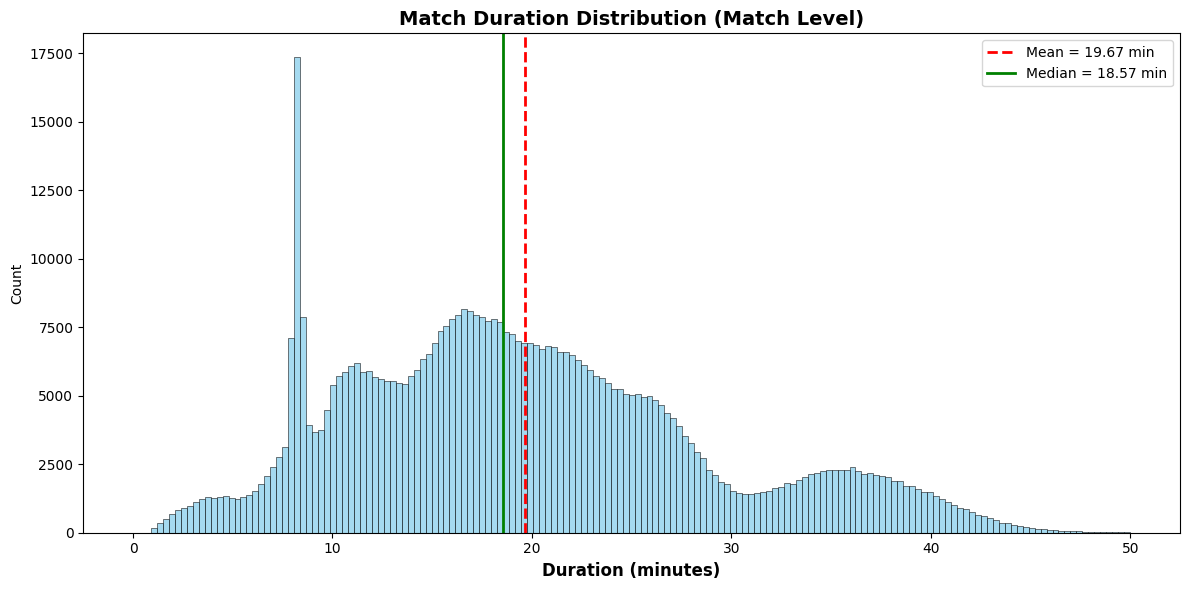

In [21]:
plt.figure(figsize=(12,6))

sns.histplot(x=df_matches['duration_in_minutes'], color="skyblue")

mean_val = df_matches['duration_in_minutes'].mean()
median_val = df_matches['duration_in_minutes'].median()

mean_line = plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {round(mean_val,2)} min")
median_line = plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f"Median = {round(median_val,2)} min")

plt.title("Match Duration Distribution (Match Level)", fontsize=14, weight="bold")
plt.xlabel("Duration (minutes)", fontsize=12, weight="bold")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


There’s no strong relationship between match duration and the number of players, however it does seem like **bigger match sizes lead to less extreme match durations.**


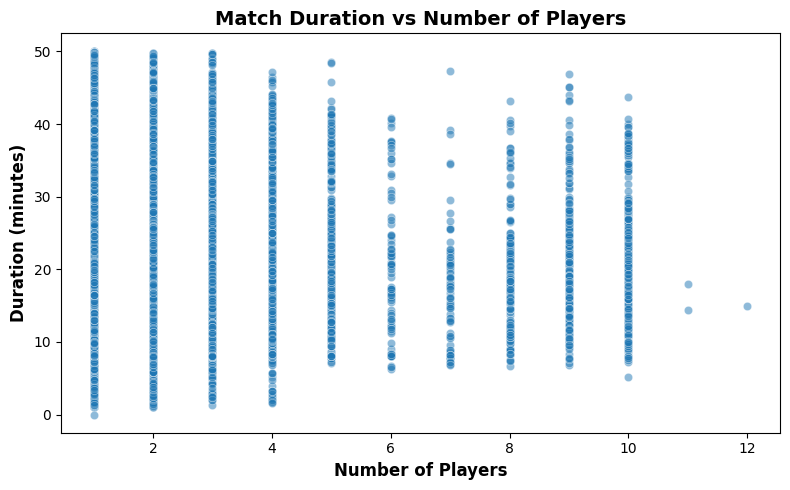

In [22]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_matches,
    x='number_of_players',
    y='duration_in_minutes',
    alpha=0.5
)

plt.title("Match Duration vs Number of Players", fontsize=14, weight='bold')
plt.xlabel("Number of Players", fontsize=12, weight='bold')
plt.ylabel("Duration (minutes)", fontsize=12, weight='bold')

plt.tight_layout()
plt.show()


### **2. trends time**

**The number of games seems to be decreasing over time during this august month**. There are patterns, but there is a clear deacreasing trend based on the 7 day moving average.

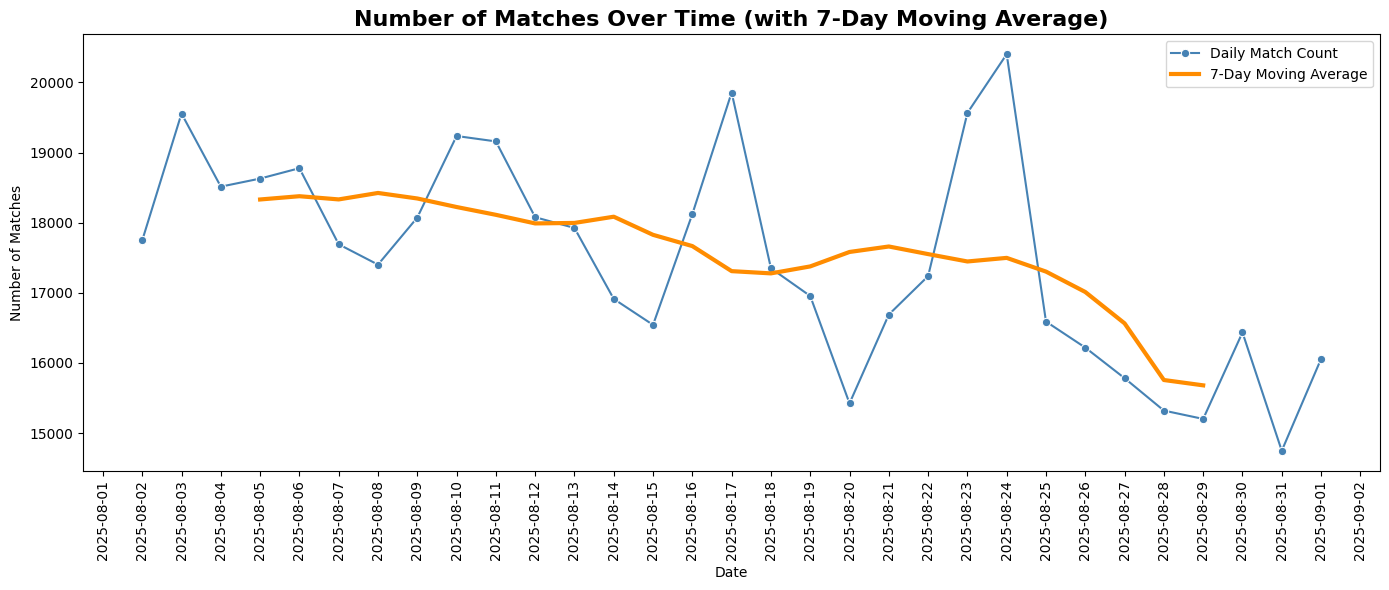

In [23]:
matches_per_day = (
    df_matches
    .groupby('date_of_match')
    .size()
    .reset_index(name='match_count')
)

matches_per_day['rolling_mean'] = matches_per_day['match_count'].rolling(window=7, center=True).mean()


plt.figure(figsize=(14,6))

sns.lineplot(
    data=matches_per_day,
    x='date_of_match',
    y='match_count',
    marker='o',
    label='Daily Match Count',
    color='steelblue'
)

sns.lineplot(
    data=matches_per_day,
    x='date_of_match',
    y='rolling_mean',
    linewidth=3,
    label='7-Day Moving Average',
    color='darkorange'
)

# 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)

plt.title("Number of Matches Over Time (with 7-Day Moving Average)", fontsize=16, weight="bold")
plt.xlabel("Date")
plt.ylabel("Number of Matches")
plt.legend()

plt.tight_layout()
plt.show()


The evolution of average match size over time displays an inverse trend compared to the
total number of matches:

- The **number of matches decreases** over time.
- At the same time, the **average number of players per match increases** slightly.

This suggests that the decline in total matches may not necessarily reflect a drop in
player activity. Instead, players might be shifting from solo sessions toward
playing together more frequently. In other words, the dataset indicates fewer
individual matches but proportionally more multiplayer matches, possibly because
players form groups or recurrent play partners as time goes on.


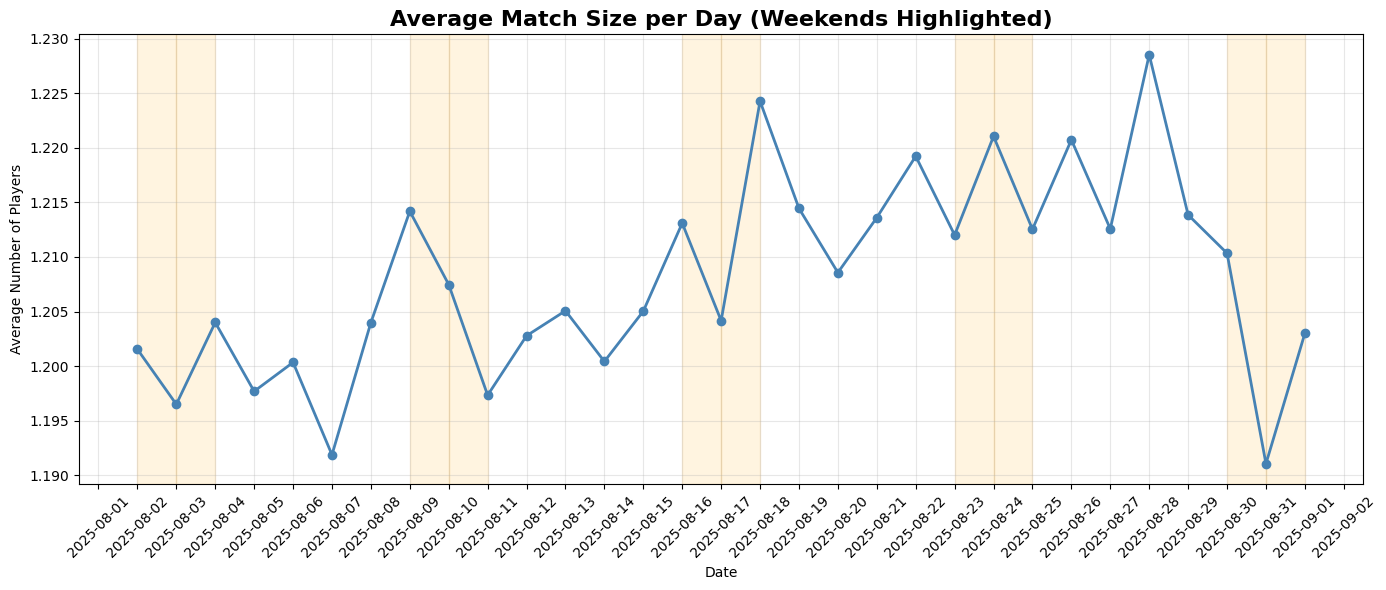

In [24]:
avg_players_per_day = (
    df_matches
    .groupby('date_of_match')['number_of_players']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,6))
plt.plot(
    avg_players_per_day['date_of_match'],
    avg_players_per_day['number_of_players'],
    marker='o',
    linewidth=2,
    color='steelblue'
)

for date, wd in zip(avg_players_per_day['date_of_match'],
                    avg_players_per_day['date_of_match'].dt.weekday):
    if wd >= 5:
        plt.axvspan(date,
                    date + pd.Timedelta(days=1),
                    color='orange',
                    alpha=0.12)

plt.title("Average Match Size per Day (Weekends Highlighted)", fontsize=16, weight='bold')
plt.xlabel("Date")
plt.ylabel("Average Number of Players")

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### **3. Gaming patterns**

Clear pattern : there are more matches during the weekends

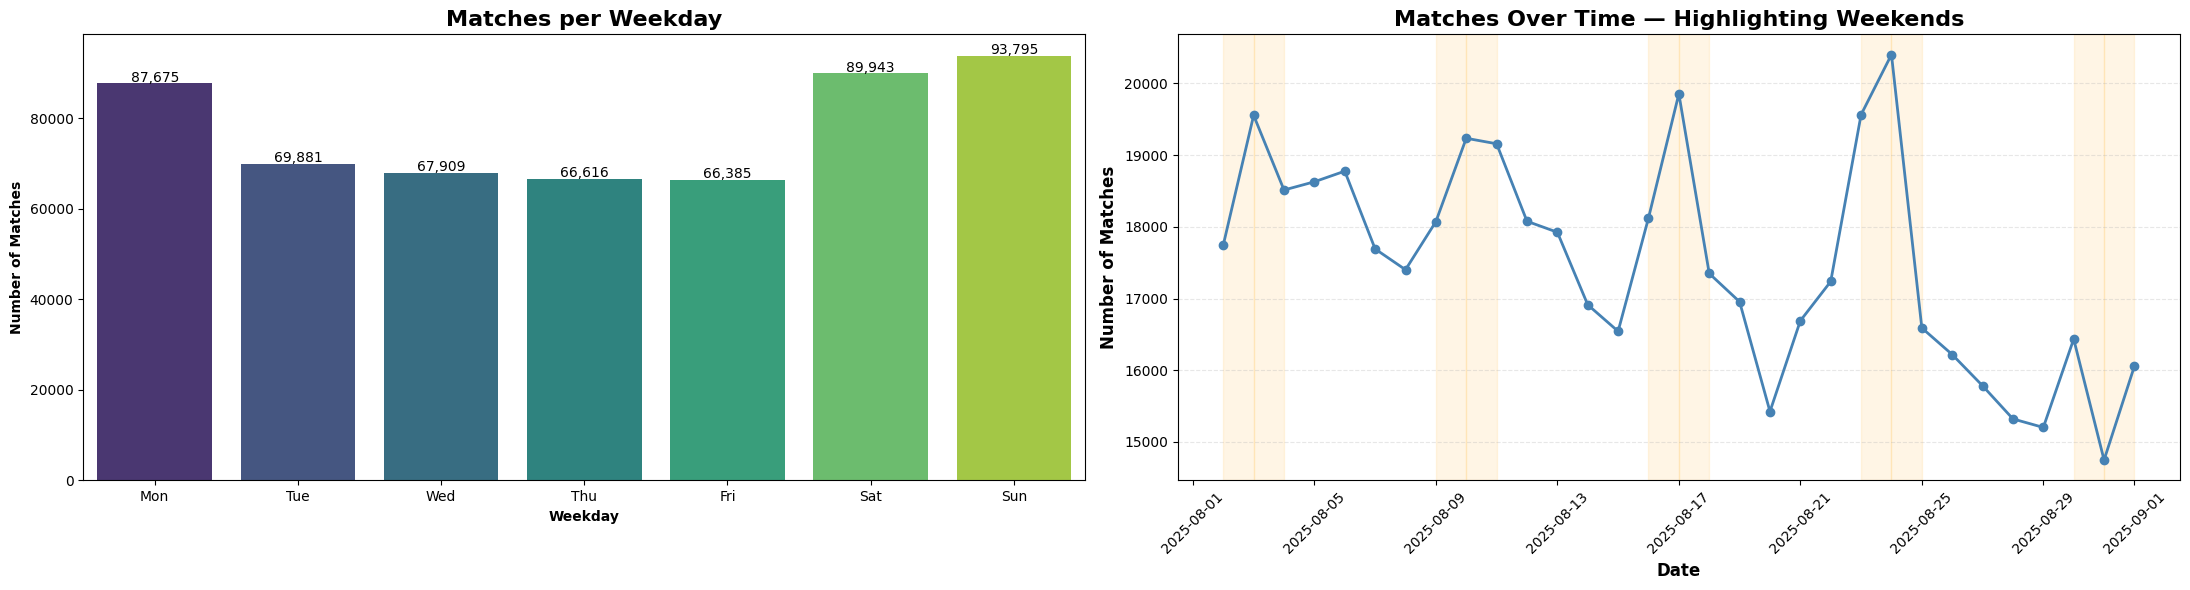

In [25]:
matches_per_weekday = (
    df_matches['weekday_of_match']
    .value_counts()
    .sort_index()
    .reset_index(name='match_count')
    .rename(columns={'index': 'weekday_of_match'})
)

weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
matches_per_weekday['weekday_name'] = matches_per_weekday['weekday_of_match'].map(
    lambda x: weekday_labels[x]
)

matches_per_day = (
    df_matches
    .groupby('date_of_match')
    .size()
    .reset_index(name='match_count')
)

fig, axes = plt.subplots(1, 2, figsize=(22, 6))

# ===================================================
# LEFT: BARPLOT OF MATCHES PER WEEKDAY
# ===================================================
sns.barplot(
    ax=axes[0],
    data=matches_per_weekday,
    x='weekday_name',
    y='match_count',
    hue='weekday_name',
    palette='viridis',
    legend=False
)

axes[0].set_title("Matches per Weekday", fontsize=16, weight='bold')
axes[0].set_xlabel("Weekday", weight='bold')
axes[0].set_ylabel("Number of Matches", weight='bold')

# Add labels above bars
for i, row in matches_per_weekday.iterrows():
    axes[0].text(i, row['match_count'] + 300,
                 f"{row['match_count']:,}", ha='center', fontsize=10)

# ===================================================
# RIGHT: MATCHES OVER TIME WITH WEEKENDS SHADED
# ===================================================
ax = axes[1]

ax.plot(
    matches_per_day['date_of_match'],
    matches_per_day['match_count'],
    marker='o',
    color='steelblue',
    linewidth=2
)

for date, wd in zip(matches_per_day['date_of_match'],
                    matches_per_day['date_of_match'].dt.weekday):
    if wd >= 5:
        ax.axvspan(date,
                   date + pd.Timedelta(days=1),
                   color='orange',
                   alpha=0.1)

ax.set_title("Matches Over Time — Highlighting Weekends",
             fontsize=16, weight='bold')
ax.set_xlabel("Date", fontsize=12, weight='bold')
ax.set_ylabel("Number of Matches", fontsize=12, weight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


### 4. **Match sizes** 

**It seems the great majority of matches are played in solo or two players**. This suggests that
the game is primarily played in small sessions, and large matches are either a
special mode or very uncommon events in the dataset.

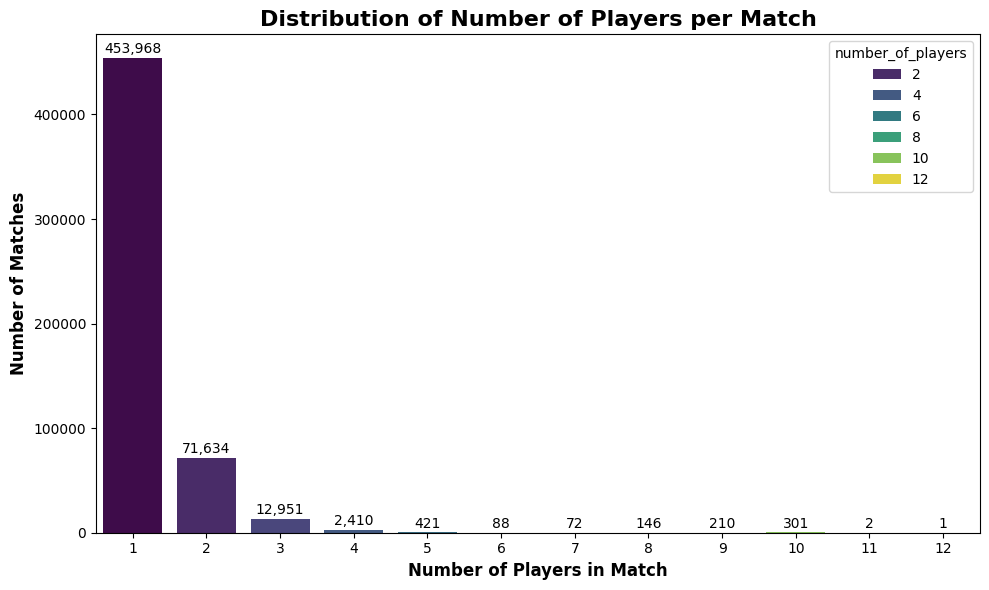

In [26]:
players_per_match_dist = (
    df_matches['number_of_players']
    .value_counts()
    .sort_index()
    .reset_index(name='match_count')
    .rename(columns={'index': 'number_of_players'})
)

plt.figure(figsize=(10,6))

sns.barplot(
    data=players_per_match_dist,
    x='number_of_players',
    y='match_count',
    hue='number_of_players',
    palette='viridis'
)

plt.title("Distribution of Number of Players per Match", fontsize=16, weight="bold")
plt.xlabel("Number of Players in Match", fontsize=12, weight='bold')
plt.ylabel("Number of Matches", fontsize=12, weight='bold')

for i, row in players_per_match_dist.iterrows():
    plt.text(i, row['match_count'] + max(players_per_match_dist['match_count']) * 0.01,
             f"{row['match_count']:,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


**Match sizes are not influenced by the day of the week**. I would have though that more players might play together during the weekend, howverer there is still the possibility that these bigger match sizes are for dedicated game modes, explaining their consistency and low frequency.

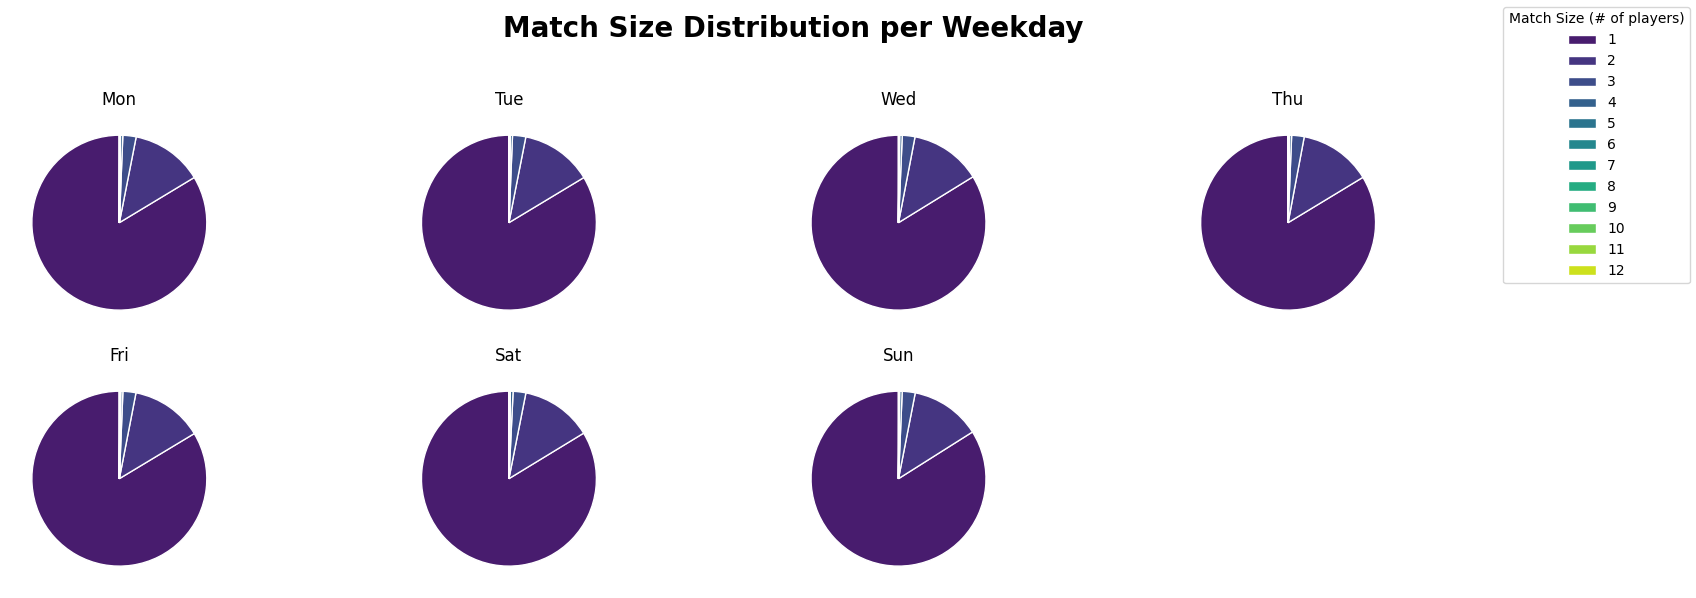

In [27]:
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_matches['weekday_name'] = df_matches['weekday_of_match'].map(lambda x: weekday_labels[x])

weekday_size_table = (
    df_matches
    .groupby(['weekday_name', 'number_of_players'])
    .size()
    .reset_index(name='count')
)

unique_sizes = sorted(df_matches['number_of_players'].unique())
colors = sns.color_palette("viridis", len(unique_sizes))
fig, axes = plt.subplots(2, 4, figsize=(18, 6))
axes = axes.flatten()

for i, weekday in enumerate(weekday_labels):
    ax = axes[i]
    
    data = weekday_size_table[weekday_size_table['weekday_name'] == weekday]
    data = data.set_index('number_of_players').reindex(unique_sizes, fill_value=0)
    
    ax.pie(
        data['count'],
        colors=colors,
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
    )
    
    ax.set_title(f"{weekday}")

fig.delaxes(axes[-1])

fig.legend(
    labels=[str(s) for s in unique_sizes],
    title="Match Size (# of players)",
    # loc="center right",
    # bbox_to_anchor=(0.92, 0.5),
    # fontsize=12
)

plt.suptitle("Match Size Distribution per Weekday", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  
plt.show()


### **5. Match structure analysis** 

Almost all matches involve **only one team**, while matches with two teams are very rare. This suggests that most sessions are either solo activities, PvE, orsingle-team scenarios rather than competitive team-vs-team matches.also this supports our previous hypothesis about specific game modes.


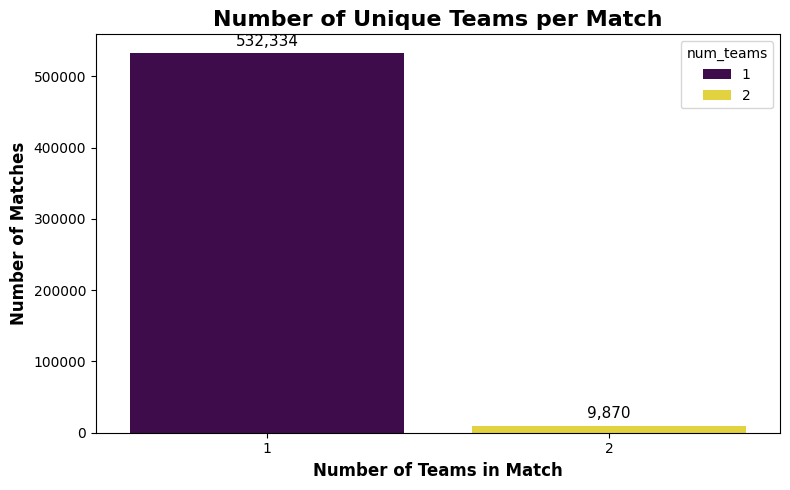

In [28]:
teams_per_match = (
    df_clean_final
    .groupby('matchid')['team']
    .nunique()
    .reset_index(name='num_teams')
)

teams_dist = (
    teams_per_match['num_teams']
    .value_counts()
    .sort_index()
    .reset_index(name='match_count')
    .rename(columns={'index': 'num_teams'})
)

plt.figure(figsize=(8,5))

sns.barplot(
    data=teams_dist,
    x='num_teams',
    y='match_count',
    palette='viridis',
    hue='num_teams'
)

plt.title("Number of Unique Teams per Match", fontsize=16, weight='bold')
plt.xlabel("Number of Teams in Match", fontsize=12, weight='bold')
plt.ylabel("Number of Matches", fontsize=12, weight='bold')

for i, row in teams_dist.iterrows():
    plt.text(
        i,
        row['match_count'] + teams_dist['match_count'].max() * 0.02,
        f"{row['match_count']:,}",
        ha='center',
        fontsize=11
    )

plt.tight_layout()
plt.show()


**team selection is apparently random during the matches.**

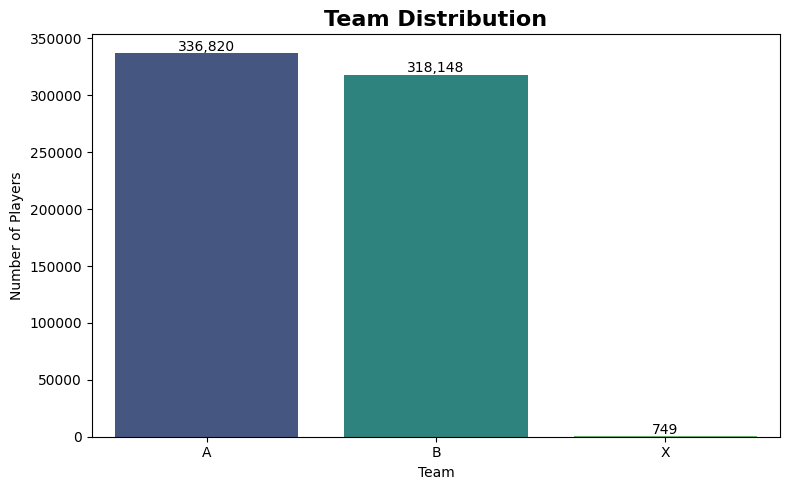

In [29]:
plt.figure(figsize=(8,5))
sns.barplot(x=team_counts.index, y=team_counts.values, palette="viridis", hue=team_counts.index)
plt.title("Team Distribution", fontsize=16, weight='bold')
plt.xlabel("Team")
plt.ylabel("Number of Players")

for i, v in enumerate(team_counts.values):
    plt.text(i, v + 2000, f"{v:,}", ha='center')

plt.tight_layout()
plt.show()


### **Analysing win rates of matches and what influences it** 

We filter on one team matches, as win rates for matches with two teams will cancel each other, as one team ones and one team loses. 

In [30]:
teams_per_match = (
    df_clean_final
    .groupby('matchid')['team']
    .nunique()
    .reset_index(name='num_teams')
)

one_team_match_ids = teams_per_match.loc[teams_per_match['num_teams'] == 1, 'matchid']
df_one_team = df_clean_final[df_clean_final['matchid'].isin(one_team_match_ids)].copy()
df_matches_one_team = df_matches[df_matches.index.isin(one_team_match_ids)].copy()
df_matches_one_team = df_matches_one_team.reset_index()

df_match_victory_one_team = (
    df_one_team
    .groupby('matchid')['victory']
    .mean()
    .reset_index(name='victory_rate')
)

matches_one_team_full = df_matches_one_team.merge(
    df_match_victory_one_team,
    on='matchid',
    how='left'
)


In [31]:

teams_per_match = (
    df_clean_final
    .groupby('matchid')['team']
    .nunique()
    .reset_index(name='num_teams')
)

one_team_match_ids = teams_per_match.loc[teams_per_match['num_teams'] == 1, 'matchid']
df_one_team = df_clean_final[df_clean_final['matchid'].isin(one_team_match_ids)].copy()
df_matches_one_team = df_matches[df_matches.index.isin(one_team_match_ids)].copy()
df_matches_one_team = df_matches_one_team.reset_index()  

df_match_victory_one_team = (
    df_one_team
    .groupby('matchid')['victory']
    .mean()
    .reset_index(name='victory_rate')
)

matches_one_team_full = df_matches_one_team.merge(
    df_match_victory_one_team,
    on='matchid',
    how='left'
)
matches_one_team_full.head()


,matchid,duration_in_minutes,number_of_players,date_of_match,weekday_of_match,weekday_name,victory_rate
0,1000,10.849417,1,2025-08-20,2,Wed,0.0
1,1001,22.160667,1,2025-08-04,0,Mon,0.0
2,1002,14.575467,1,2025-08-28,3,Thu,1.0
3,1003,0.000000,1,2025-08-27,2,Wed,1.0
4,1004,16.390700,1,2025-08-02,5,Sat,0.0


#### Victory rate in one-team matches

**The victory rate is fairly stable for match sizes from 1 to 3 players (around
50–52%), then rises slightly for larger groups**. Matches with 5 players show the
highest success rate (~61%). This suggests that in one-team scenarios, having
more players generally makes the match easier or more likely to be completed
successfully.


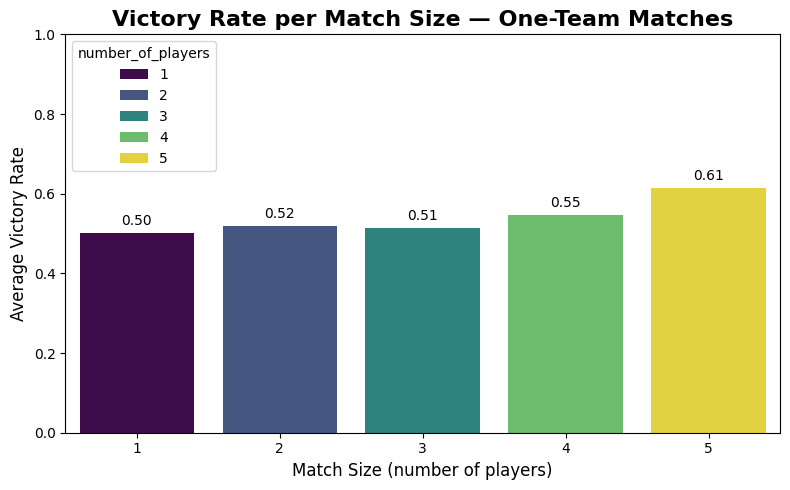

In [32]:
victory_by_size = (
    matches_one_team_full
    .groupby('number_of_players')['victory_rate']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))

sns.barplot(
    data=victory_by_size,
    x='number_of_players',
    y='victory_rate',
    palette='viridis',
    hue='number_of_players'
)

plt.title("Victory Rate per Match Size — One-Team Matches", fontsize=16, weight='bold')
plt.xlabel("Match Size (number of players)", fontsize=12)
plt.ylabel("Average Victory Rate", fontsize=12)
plt.ylim(0, 1)

for i, row in victory_by_size.iterrows():
    plt.text(i, row['victory_rate'] + 0.02,
             f"{row['victory_rate']:.2f}",
             ha='center')

plt.tight_layout()
plt.show()


#### Victory rate per weekday — one-team matches

**The victory rate is almost identical across all days of the week, staying very
close to 50%.** There’s no meaningful weekday pattern, which suggests that
player performance in one-team matches is consistent regardless of when the
match is played.


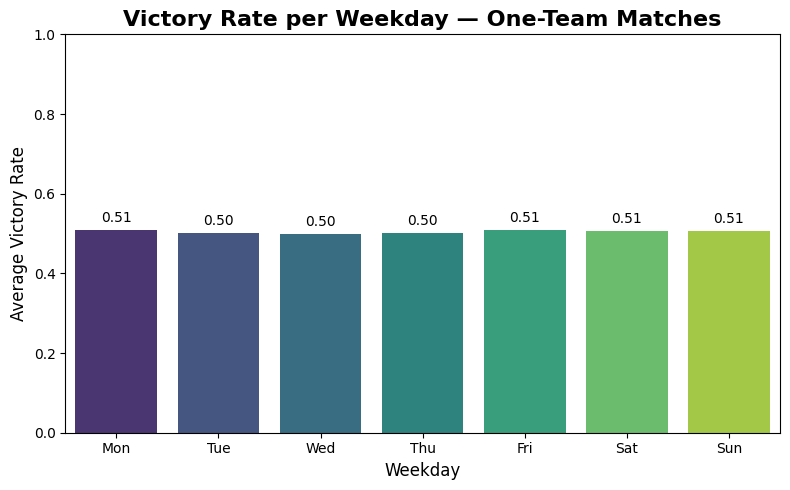

In [33]:
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

victory_by_weekday = (
    matches_one_team_full
    .groupby('weekday_of_match')['victory_rate']
    .mean()
    .reset_index()
)

victory_by_weekday['weekday_name'] = victory_by_weekday['weekday_of_match'].map(lambda x: weekday_labels[x])

plt.figure(figsize=(8,5))

sns.barplot(
    data=victory_by_weekday,
    x='weekday_name',
    y='victory_rate',
    palette='viridis',
    hue='weekday_name'
)

plt.title("Victory Rate per Weekday — One-Team Matches", fontsize=16, weight='bold')
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Average Victory Rate", fontsize=12)
plt.ylim(0, 1)

for i, row in victory_by_weekday.iterrows():
    plt.text(i, row['victory_rate'] + 0.02,
             f"{row['victory_rate']:.2f}",
             ha='center')

plt.tight_layout()
plt.show()


#### Victory rate by match duration — one-team matches

Short matches (under 10 minutes) have a noticeably lower victory rate (~30%), which likely indicates early failures or quick abandons. **It makes sense and supports our previous hypothesis about 8-9 min being a default time for surrendering or timeout, which explains why 8min is the most common duration time, and why they are more often losses.**

For all longer durations, the victory rate stabilizes around 54%, with no major differences between 10–20, 20–30, or 30–49 minute matches. This suggests that once a match passes the early phase, the success rate becomes much more consistent.


C:\Users\IJI5\AppData\Local\Temp\ipykernel_10936\1896682720.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('duration_bucket')['victory_rate']


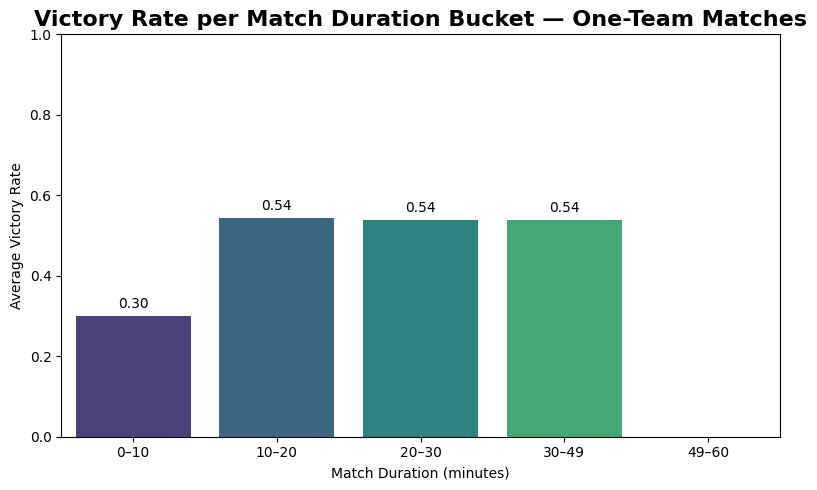

In [34]:
max_dur = matches_one_team_full['duration_in_minutes'].max()

bins = [0, 10, 20, 30, 60, max_dur]
bins = sorted(set(bins)) 

labels = [f"{int(bins[i])}–{int(bins[i+1])}" for i in range(len(bins)-1)]

matches_one_team_full['duration_bucket'] = pd.cut(
    matches_one_team_full['duration_in_minutes'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

victory_by_duration_bucket = (
    matches_one_team_full
    .groupby('duration_bucket')['victory_rate']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=victory_by_duration_bucket,
    x='duration_bucket',
    y='victory_rate',
    palette='viridis',
    hue='duration_bucket'
)
plt.title("Victory Rate per Match Duration Bucket — One-Team Matches", fontsize=16, weight='bold')
plt.xlabel("Match Duration (minutes)")
plt.ylabel("Average Victory Rate")
plt.ylim(0, 1)

for i, row in victory_by_duration_bucket.iterrows():
    plt.text(i, row['victory_rate'] + 0.02,
             f"{row['victory_rate']:.2f}", ha='center')

plt.tight_layout()
plt.show()


**FUN FACT : It seems that the best chance to win a game is to have a 5 player team on sunday !**

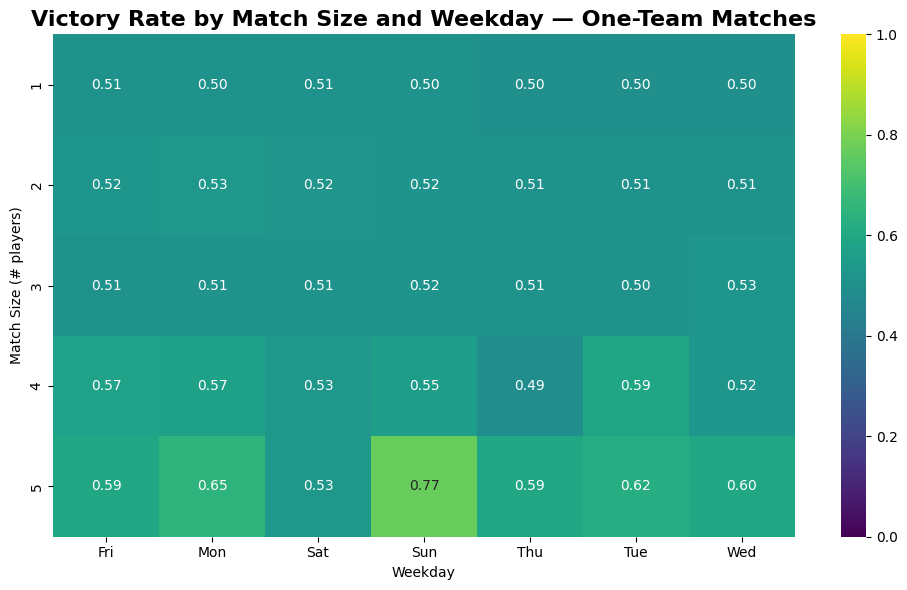

In [35]:
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
matches_one_team_full['weekday_name'] = matches_one_team_full['weekday_of_match'].map(lambda x: weekday_labels[x])

victory_size_weekday = (
    matches_one_team_full
    .groupby(['number_of_players', 'weekday_name'])['victory_rate']
    .mean()
    .reset_index()
)

victory_size_weekday_pivot = victory_size_weekday.pivot(
    index='number_of_players',
    columns='weekday_name',
    values='victory_rate'
)

plt.figure(figsize=(10,6))
sns.heatmap(
    victory_size_weekday_pivot,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    vmin=0,
    vmax=1
)
plt.title("Victory Rate by Match Size and Weekday — One-Team Matches", fontsize=16, weight='bold')
plt.xlabel("Weekday")
plt.ylabel("Match Size (# players)")
plt.tight_layout()
plt.show()


C:\Users\IJI5\AppData\Local\Temp\ipykernel_10936\3202638957.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


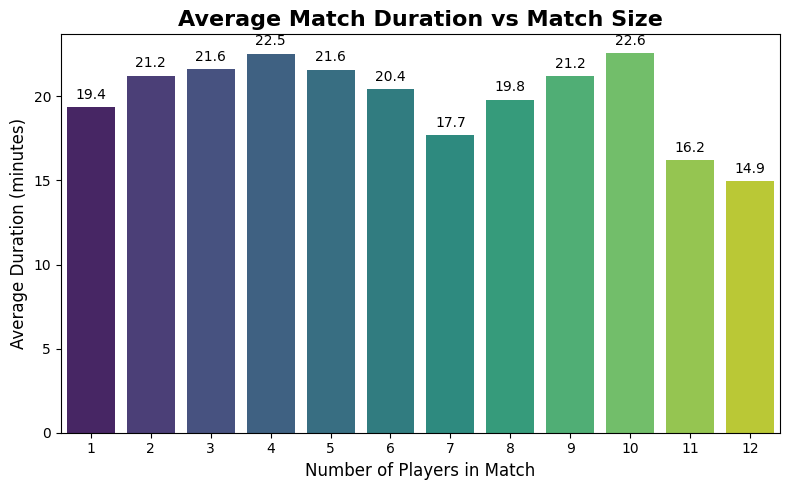

In [36]:
avg_duration_by_size = (
    df_matches
    .groupby('number_of_players')['duration_in_minutes']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))

sns.barplot(
    data=avg_duration_by_size,
    x='number_of_players',
    y='duration_in_minutes',
    palette='viridis'
)

plt.title("Average Match Duration vs Match Size", fontsize=16, weight='bold')
plt.xlabel("Number of Players in Match", fontsize=12)
plt.ylabel("Average Duration (minutes)", fontsize=12)

for i, row in avg_duration_by_size.iterrows():
    plt.text(
        i,
        row['duration_in_minutes'] + 0.5,
        f"{row['duration_in_minutes']:.1f}",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()


### **In a nutshell : What does the dataset tell us about the game matches?**

### **1. Match duration patterns**
- Match durations clearly fall into **two groups**:
  - short matches around **7–10 minutes**, including a large spike at one
    specific duration (likely a fixed timeout or early-surrender event),
  - longer matches around **15–25 minutes**, which represent the majority of
    normal gameplay.
- The **average duration is ~19.7 minutes**, with a long tail up to 40–50 minutes.
- Overall, the distribution suggests **different match types or end conditions**.

### **2. Number of players and match size**
- Most matches are extremely small: **solo** or **two-player** sessions dominate the dataset.
- Larger match sizes (6+ players) are rare, suggesting they correspond to
  **specific game modes** rather than typical play.
- Match duration does **not strongly depend** on the number of players, though
  very large and 7-player matches tend to end a bit faster.

### **3. Number of teams per match**
- Almost all matches involve **a single team**, while two-team matches are very rare.
- This indicates the dataset is dominated by **solo/PvE/single-team modes**
  rather than competitive team-vs-team matches.

### **4. Temporal patterns**
- The **number of matches decreases** over the month of August.
- However, the **average match size increases slightly**, suggesting players may
  shift from solo play toward small groups rather than reducing activity.
- Clear weekly rhythm: **more matches are played on weekends**.

### **5. Victory patterns (one-team matches)**
- Victory rate is stable for match sizes 1–3 (~50–52%) and increases for larger
  groups; **5-player teams win the most (~61%)**.
- Victory rate is **consistent across weekdays**, around 50%.
- Short matches (<10 min) have a **low win rate (~30%)**, supporting the idea
  that many of them end early due to surrender/timeout.
- For all longer durations, win rate stabilizes around ~54%.

### **Overall insight**
The dataset reflects a game where:
- most sessions are **small, single-team matches**,
- match durations follow **two gameplay patterns** (early termination vs full match),
- player behaviour follows **weekend activity cycles**,
- and winning is influenced more by **match duration and team size** than by
  weekday or total number of players.


# **Q4. Compute all players win/lose ratio and display distribution**

In [37]:
player_stats = df_clean_final.groupby("playerid").agg(
    wins=("victory", "sum"),
    total_matches=("victory", "count")
)

player_stats["losses"] = player_stats["total_matches"] - player_stats["wins"]
player_stats["win_ratio"] = player_stats["wins"] / player_stats["total_matches"]

player_stats.head()


,wins,total_matches,losses,win_ratio
playerid,,,,
10001,65,109,44,0.596330
10002,64,129,65,0.496124
10003,69,172,103,0.401163
10004,55,83,28,0.662651
10005,142,364,222,0.390110


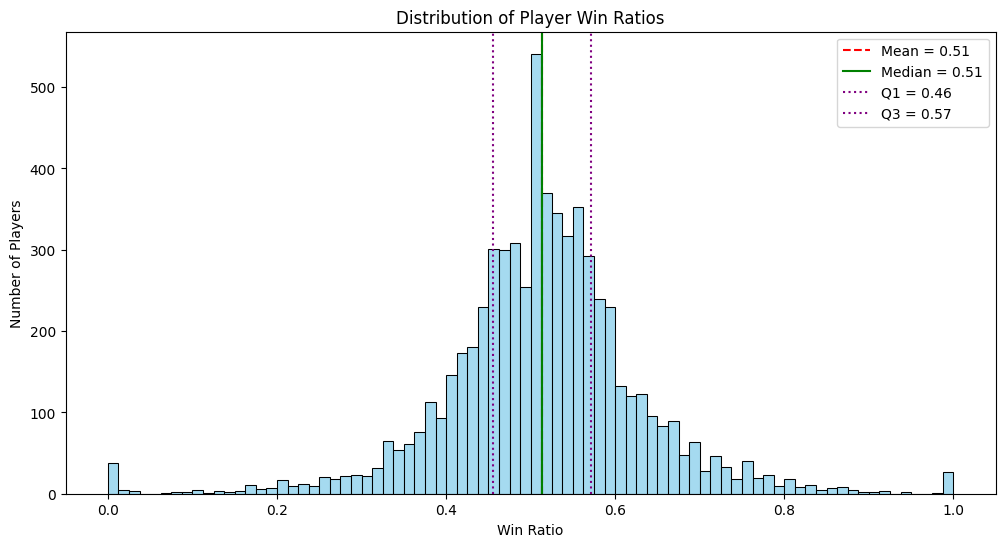

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_val = player_stats["win_ratio"].mean()
median_val = player_stats["win_ratio"].median()
q1 = player_stats["win_ratio"].quantile(0.25)
q3 = player_stats["win_ratio"].quantile(0.75)

plt.figure(figsize=(12,6))

sns.histplot(
    player_stats["win_ratio"],
    kde=False,
    color="skyblue",
    edgecolor="black"
)

plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color="green", linestyle="-", linewidth=1.5, label=f"Median = {median_val:.2f}")
plt.axvline(q1, color="purple", linestyle=":", linewidth=1.5, label=f"Q1 = {q1:.2f}")
plt.axvline(q3, color="purple", linestyle=":", linewidth=1.5, label=f"Q3 = {q3:.2f}")

plt.title("Distribution of Player Win Ratios")
plt.xlabel("Win Ratio")
plt.ylabel("Number of Players")
plt.legend()
plt.show()


# **Q5. Compute all players max defeat and victory in a row**

**We group by player id, then order by date in order to corectly count win streaks and loss streaks**

In [39]:
def max_streak(values, target):
    max_s = 0
    cur_s = 0
    for v in values:
        if v == target:
            cur_s += 1
        else:
            cur_s = 0
        if cur_s > max_s:
            max_s = cur_s
    return max_s

df_sorted = df_clean_final.sort_values(["playerid", "matchdateid"])

player_streaks = df_sorted.groupby("playerid").agg(
    max_win_streak=("victory", lambda x: max_streak(x, 1)),
    max_loss_streak=("victory", lambda x: max_streak(x, 0))
).reset_index()

player_streaks.head()


,playerid,max_win_streak,max_loss_streak
0,10001,16,4
1,10002,6,6
2,10003,5,14
3,10004,6,3
4,10005,8,15


# **Q6. Compute/aggregate other players features you think are relevant and keep all players features in a dataframe**

### Basic Performance Features

- `wins`
  Total number of victories for the player.  
  

- `losses`
  Total number of defeats.  


- `avg_teammates`  
  Average number of teammates in the matches a player participated in. My hypothesis is that a player which has friends to play with might be more prone to still be active


In [40]:
basic_features = player_stats[["wins", "losses"]].copy()

match_sizes = df_sorted.groupby("matchid")["playerid"].nunique().rename("match_size")
df_with_size = df_sorted.merge(match_sizes, on="matchid", how="left")

avg_teammates = df_with_size.groupby("playerid").agg(
    avg_teammates=("match_size", lambda x: (x - 1).mean())
)

basic_features = basic_features.join(avg_teammates)
basic_features.head()


,wins,losses,avg_teammates
playerid,,,
10001,65,44,0.669725
10002,64,65,0.744186
10003,69,103,0.058140
10004,55,28,1.240964
10005,142,222,0.337912


### **1. Engagement features**

These features summarize **how much and how often** each player engages with the game.

- `n_matches`  
  Total number of matches played by the player.  
  → Simple proxy for overall experience and engagement level.

- `n_active_days`  
  Number of distinct calendar days in which the player played at least one match.  

- `matches_per_active_day`  
  Ratio `n_matches / n_active_days`.  
  → Distinguishes between players who binge-play on a few days 
  and those who play a small number of matches regularly.

These variables may be strong predictors of retention and long-term value:
high volume, frequent play and regular habits are probably associated with a higher
probability of being `still_active`.


In [41]:
df_sorted = df_clean_final.sort_values(["playerid", "matchdateid"])

engagement_features = df_sorted.groupby("playerid").agg(
    n_matches=("matchid", "count"),
    n_active_days=("matchdateid", lambda x: x.dt.date.nunique())
)

engagement_features["matches_per_active_day"] = (
    engagement_features["n_matches"] /
    engagement_features["n_active_days"].replace(0, np.nan)
)

engagement_features.head()


,n_matches,n_active_days,matches_per_active_day
playerid,,,
10001,109,18,6.055556
10002,129,23,5.608696
10003,172,26,6.615385
10004,83,8,10.375000
10005,364,23,15.826087


### **2. Career length & progression**

These features describe the **span of a player's life in the game**.

- `first_match_date`  
  Date of the first recorded match of the player.

- `last_match_date`  
  Date of the most recent recorded match.

- `lifetime_days`  
  Difference (in days) between `last_match_date` and `first_match_date`.

A longer lifetime usually indicates a player who has integrated the game into
their habits and is less likely to churn. Recent players with a very short
career may be at higher risk of abandoning the game.


In [42]:
career_features = df_sorted.groupby("playerid").agg(
    first_match_date=("matchdateid", "min"),
    last_match_date=("matchdateid", "max")
)

career_features["lifetime_days"] = (
    career_features["last_match_date"] - career_features["first_match_date"]
).dt.days

career_features.head()


,first_match_date,last_match_date,lifetime_days
playerid,,,
10001,2025-08-04,2025-09-01,28
10002,2025-08-02,2025-09-01,30
10003,2025-08-04,2025-09-01,28
10004,2025-08-08,2025-08-24,16
10005,2025-08-02,2025-09-01,30


### **3. Recency features**

Recency is one of the strongest signals for churn: players who have not played
recently are unlikely to still be active.

- `days_since_last_match`  
  Number of days between the reference date (latest match in the dataset) and
  the player's last match.

- `matches_last_7d`  
  Number of matches played in the last 7 days.

- `matches_last_14d`  
  Number of matches played in the last 14 days.

Players with 0 recent matches and a high `days_since_last_match` are strong
candidates for `still_active = 0`.


In [43]:
reference_date = df_clean_final["matchdateid"].max()

recency_main = df_sorted.groupby("playerid").agg(
    days_since_last_match=("matchdateid", lambda x: (reference_date - x.max()).days)
)

def matches_last_x_days(df_player, x):
    ref = reference_date
    return (df_player["matchdateid"] >= ref - pd.Timedelta(days=x)).sum()

recency_windows = df_sorted.groupby("playerid").apply(
    lambda x: pd.Series({
        "matches_last_7d": matches_last_x_days(x, 7),
        "matches_last_14d": matches_last_x_days(x, 14)
    })
)

recency_features = recency_main.join(recency_windows)
recency_features.head()


C:\Users\IJI5\AppData\Local\Temp\ipykernel_10936\1049676242.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recency_windows = df_sorted.groupby("playerid").apply(


,days_since_last_match,matches_last_7d,matches_last_14d
playerid,,,
10001,0,8,23
10002,0,33,58
10003,0,57,90
10004,8,0,17
10005,0,65,74


### **4. Performance consistency**

Beyond raw winrate, we can look at how **stable** or **evolving** a player's
performance is over time.

To do this, I compute winrate per player and per month, then aggregate:

- `winrate_std`  
  Standard deviation of monthly winrate.  
  → High values indicate an unstable player (big swings between months),
  which can be a sign of frustration or changing skill level.

- `winrate_trend`  
  Difference between last-month winrate and first-month winrate.  
  → Positive trend: improving player (possibly more engaged and motivated).  
  → Negative trend: declining performance (could correlate with churn).

These indicators are complementary to the global `win_ratio` computed earlier.


In [44]:

df_tmp = df_clean_final.copy()
df_tmp["year_month"] = df_tmp["matchdateid"].dt.to_period("M")

winrate_monthly = (
    df_tmp.groupby(["playerid", "year_month"])["victory"]
    .mean()
    .reset_index()
)

def compute_winrate_trend(df_player):
    if len(df_player) <= 1:
        return 0.0
    return df_player["victory"].iloc[-1] - df_player["victory"].iloc[0]

performance_features = winrate_monthly.groupby("playerid").agg(
    winrate_std=("victory", "std")
)

performance_features["winrate_trend"] = (
    winrate_monthly.groupby("playerid")
    .apply(compute_winrate_trend)
)

performance_features.head()


C:\Users\IJI5\AppData\Local\Temp\ipykernel_10936\609281593.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_winrate_trend)


,winrate_std,winrate_trend
playerid,,
10001,0.288081,0.407407
10002,0.079624,0.112605
10003,0.191072,0.270217
10004,NaN,0.000000
10005,0.081277,0.114943


### **5. Playtime behaviour**

These features describe **how** the player consumes the game in terms of
session length and spacing between sessions.

- `avg_duration`, `median_duration`, `std_duration`  
  Summary statistics of match duration (in minutes).  
  → Short, highly variable sessions can indicate casual or experimenting
  players; long, stable durations often correspond to more invested players.

- `mean_gap_days`, `median_gap_days`  
  Average and median number of days between two consecutive matches.  
  → Small gaps indicate a regular player; large gaps suggest sporadic play
  and higher churn risk.


In [45]:

duration_features = df_sorted.groupby("playerid").agg(
    avg_duration=("duration_minutes", "mean"),
    median_duration=("duration_minutes", "median"),
    std_duration=("duration_minutes", "std")
)

df_sorted["prev_match"] = df_sorted.groupby("playerid")["matchdateid"].shift(1)
df_sorted["gap_days"] = (
    df_sorted["matchdateid"] - df_sorted["prev_match"]
).dt.days

pace_features = df_sorted.groupby("playerid").agg(
    mean_gap_days=("gap_days", "mean"),
    median_gap_days=("gap_days", "median")
)

playtime_features = duration_features.join(pace_features)
playtime_features.head()


,avg_duration,median_duration,std_duration,mean_gap_days,median_gap_days
playerid,,,,,
10001,17.723242,16.639517,9.375580,0.259259,0.0
10002,25.699986,24.424617,7.627226,0.234375,0.0
10003,17.446784,15.737392,8.926936,0.163743,0.0
10004,25.548831,24.257567,8.615234,0.195122,0.0
10005,10.776283,8.148575,6.162404,0.082645,0.0


### **6. Final player-level feature table**

I now gather all previously engineered features into a single dataframe with:

- one row per `playerid`
- behavioural / engagement features
- performance features (including win/loss ratio and streaks computed earlier)
- recency and career-length indicators
- playtime statistics

This table will be the basis for:
- **Q7**: building a model to predict `still_active`
- **Q8**: analysing feature importance for player retention


In [46]:
player_features = (
    player_stats
    .merge(player_streaks, on="playerid")
    .merge(engagement_features, on="playerid")
    .merge(career_features, on="playerid")
    .merge(recency_features, on="playerid")
    .merge(performance_features, on="playerid")
    .merge(playtime_features, on="playerid")
    .merge(basic_features, on="playerid")
    .reset_index()
)

player_features


,index,playerid,wins_x,total_matches,losses_x,win_ratio,max_win_streak,max_loss_streak,n_matches,n_active_days,...,winrate_std,winrate_trend,avg_duration,median_duration,std_duration,mean_gap_days,median_gap_days,wins_y,losses_y,avg_teammates
0,0,10001,65,109,44,0.596330,16,4,109,18,...,0.288081,0.407407,17.723242,16.639517,9.375580,0.259259,0.0,65,44,0.669725
1,1,10002,64,129,65,0.496124,6,6,129,23,...,0.079624,0.112605,25.699986,24.424617,7.627226,0.234375,0.0,64,65,0.744186
2,2,10003,69,172,103,0.401163,5,14,172,26,...,0.191072,0.270217,17.446784,15.737392,8.926936,0.163743,0.0,69,103,0.058140
3,3,10004,55,83,28,0.662651,6,3,83,8,...,NaN,0.000000,25.548831,24.257567,8.615234,0.195122,0.0,55,28,1.240964
4,4,10005,142,364,222,0.390110,8,15,364,23,...,0.081277,0.114943,10.776283,8.148575,6.162404,0.082645,0.0,142,222,0.337912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6378,6378,16379,140,261,121,0.536398,7,5,261,27,...,NaN,0.000000,24.572773,23.341817,7.582250,0.107692,0.0,140,121,0.674330
6379,6379,16380,55,89,34,0.617978,7,5,89,17,...,0.441942,-0.625000,17.099243,16.020700,6.320249,0.340909,0.0,55,34,0.674157
6380,6380,16381,36,63,27,0.571429,5,4,63,26,...,NaN,0.000000,25.391080,23.053050,8.500778,0.451613,0.0,36,27,0.095238
6381,6381,16382,48,98,50,0.489796,5,7,98,11,...,NaN,0.000000,24.694591,24.292325,8.557897,0.257732,0.0,48,50,0.173469


### **Cleaning redundant features**

Before building the final player-level feature table, we remove a few redundant
columns to avoid duplicated information:

- **Duplicate `wins` and `losses` columns**  
  They are both in `player_stats` and inside the basic features section, so
  we keep a single copy in the final dataframe.

- **`first_match_date` and `last_match_date`**  
  These two variables are useless because we have:
  - `lifetime_days` (difference between first and last match)
  - `days_since_last_match` (recency)

This ensures our final feature dataset does not have
multicollinearity.


In [47]:
player_features = player_features.drop(columns=["first_match_date", "last_match_date", "wins_y", "losses_y"])

# **Q7. Based on the players features computed, can you think of a method to predict the 'still_active' one (explain what you would do, no need to write working code)**

To predict whether a player is *still active*, I would treat the problem as a
**binary classification task** using the player-level feature table previously
constructed. Here is the general approach I would follow.


#### **1. Merge with the original dataset to attach the target**

We first need to merge the engineered player feature table with `"still_active"` from
the original dataset (`df_clean_final`).  
Since the `"still_active"` is consistent per player, we take the last known value:

- merge on `playerid`
- extract a single `still_active` per player


#### **2. Preprocessing & cleaning**

Before modeling, I would apply:

- **removal of redundant features** 
- **imputation** for missing values, like mean for numerical features and most common for categorical features
- **normalization or scaling** (optional for tree models, recommended for linear models)

These first three steps like the outlier removal were already done in the previous questions, so all there is left to do is :

- **scaling / normalization**  
  Standardize numerical features so that all models receive features on comparable scales to avoid learning issues.
- **feature encoding** : all features are numerical, so there is no need for one hot or label encoding, 
- **train/validatio/test split** at the *player* level. validation set is for hyperparameter tuning, test set is for evaluation. We could also just split into train and test, and use k-fold cross validation.
- **stratification** to preserve the ratio of active vs inactive players


#### **3. Choice of the model for the prediction task**

Since this is a binary classification problem, several
model can be used.

My strategy would be:

- **Start with a simple baseline model like Logistic Regression**, in order to get a first baseline, is easy to interpret.

- **Then use a more powerful model such as XGBoost or random forest** which typically performs the best, as it reduces bias by using boosting and controls variance. Also we can extract feature importance from XGBoost. The advantage of a random forest is its explainability, as a tree is readable by humans


#### **4. Model training procedure**

I would apply:

- **Train / Test split :**  80% / 20%, stratified  
- **K-Fold Cross-Validation** on the training set for in order to learn the best hyperparameters without cheating by doing it on the test set  
- Hyperparameter optimisation:
  - XGBoost: learning_rate, max_depth, n_estimators, subsample  
  - RandomForest: number of trees, max_depth  

Evaluation metrics:

- **F1-score** which is great for unbalanced datasets like ours, as there are a lot more active players than inactive.
- **ROC-AUC** 


#### **5. Prediction & inference**

Once trained:

- evaluate on the test set   


#### **6. Iteration and model refinement**

After training the first models, I would iterate to understand what works and
what doesn’t:

- **Look at the confusion matrix** to see which class the model struggles with.
- **Check the classification report** to understand the
  type of errors being made.

# **Q8. How would you analyse players features importance for still_active predictor (explain what you would do, no need to write  working code)**

To understand which features drive the model’s predictions, I would look at
importance from different angles.

- First, I would check **XGBoost’s built-in feature importance** to
get a quick overview of which features the model relies on the most.

- Then, for a more detailed and reliable interpretation, I would use **SHAP
values**, which work very well with tree models and show both global importance
and how each feature influences individual predictions.

- Finally, I could also use **LIME** to inspect a few specific players. LIME is a library which
provides local explanations and helps verify whether the model behaves reasonably
in concrete cases for a player with low engagement and long inactivity.

Using SHAP for global patterns and LIME for individual cases gives a complete
and easy-to-explain view of the model’s decision process.


# **Q9. BONUS : Improvemement ideas**

As we can see, the dataset is unbalanced. Because of this, we can expect the
confusion matrix to show:

- **high recall and precision for the majority class**  
- **lower recall and precision for the minority class**  

This is typical in imbalanced datasets, because the models learns that it has a lower error rate if it focuses on predicting the majority
class more accurately.


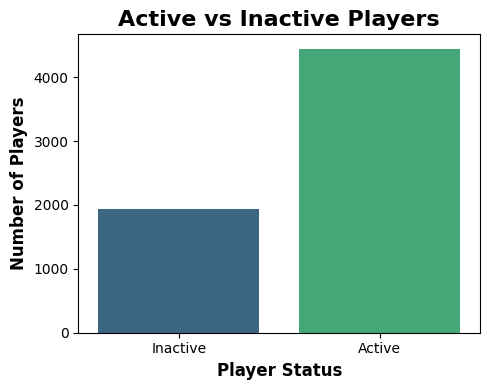

In [48]:
player_activity = (
    df_clean_final
    .groupby("playerid")["still_active"]
    .last()
)

counts = player_activity.value_counts().sort_index()

# Map both bool and int indices to labels
label_map = {0: "Inactive", 1: "Active", False: "Inactive", True: "Active"}
labels = [label_map[idx] for idx in counts.index]

plt.figure(figsize=(5, 4))
sns.barplot(
    x=labels,
    y=counts.values,
    palette="viridis",
    hue=labels,
)
plt.title("Active vs Inactive Players", fontsize=16, weight='bold')
plt.ylabel("Number of Players", fontsize=12, weight='bold')
plt.xlabel("Player Status", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In order to deal with this issue, we have **4 main options**:

- **Upsampling** : Increase the number of minority-class samples. This can be done by using libraries such as SMOTE to artficially create data for the minority class.

- **Downsampling** : Reduce the number of majority-class samples to balance the dataset, usually by deleting rows from the majority class.

- **Class weighting** : Give a higher weight to the minority class so the model pays more attention to it, by playing with the model hyperparameters. 

- **Two-stage model**: We can extract the probability the model has of predicting. If it is close to the middle, for exemple 55% of being an active player, we can say that because the dataset is unbalanced, it may be that this player is actually inactive, but the model is unsure and biased to say it is active. So, fopr instances where the model is unsure, use another model specifically trained on these edge cases.



### **Other Possible improvements**

To go further, I would explore a few improvements:

- **Better hyperparameter search**  
  Start with a **RandomizedSearchCV** on a wide space of hyperparameters as it is quicker, then refine
  with a smaller **GridSearchCV** around the best region, using K-Fold CV.

- **Error analysis by segment**  
  Analyse model errors by subgroups, like new vs veteran players, low vs high
  engagement, to see where the model fails and design targeted features.
.


### **Other ML pipelines**

Beyond tuning a single model, we could improve the overall architecture of the
pipeline:

- **Ensemble of models**  
  Combine several models instead of relying on one:
  - average the probabilities of Logistic Regression + XGBoost,
  - or use stacking.  

- **Using clustering to improve the `still_active` prediction** : We can use clustering to identify different **player types** before running the
classification model.

  - 1. Clustering as a feature-engineering step : Run a method like K-Means on the player-level features to group players by player type. Add the **cluster ID** as an extra feature: the classifier can then learn different churn patterns for each player type.

  - 2. Cluster-specific models : Alternatively, train **one model per cluster** instead of a single global model. Each model focuses on a more homogeneous group of players, which can improve accuracy and make interpretation easier.


